In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pandas as pd
from StockTradingRLEnv_Abhi import StockTradingEnv
import matplotlib.pyplot as plt


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [3]:
class DDQNAgent:
    def __init__(self, state_dim, is_eval=False, model_name=""):
        self.state_dim = state_dim
        self.action_dim = 3  # 0: buy, 1: sell, 2: hold
        self.memory = deque(maxlen=100)
        self.buffer_size = 60

        self.tau = 0.0001
        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.995
        self.is_eval = is_eval

        self.model = DQN(state_dim, self.action_dim)
        self.target_model = DQN(state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()

        if self.is_eval:
            self.model.load_state_dict(torch.load(f'saved_models/{model_name}'))
            self.target_model.load_state_dict(torch.load(f'saved_models/{model_name}'))
        else:
            self.update_target_model()

    def update_target_model(self):
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state,explore=True):
        if(explore):
            if not self.is_eval and random.random() <= self.epsilon:
                return [random.randrange(self.action_dim),random.random()]
            state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        action_type = torch.argmax(q_values[0]).item()
        amount = random.random()  # percentage to buy/sell
        return [action_type, amount]

    def replay(self):
        if len(self.memory) < self.buffer_size:
            return

        minibatch = random.sample(self.memory, self.buffer_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)

            target = self.model(state)[0]
            if done:
                target[action] = reward
            else:
                next_action = torch.argmax(self.model(next_state)[0]).item()
                t = self.target_model(next_state)[0]
                target[action] = reward + self.gamma * t[next_action].item()

            target = target.unsqueeze(0)
            output = self.model(state)
            loss = self.loss_fn(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), f'saved_models/{name}')


In [4]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_STEPS = 2000

# INITIAL_ACCOUNT_BALANCE = 10000

In [5]:
df = pd.read_csv('./data/^GSPC_2010-2015.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.reset_index(drop=True)

env = StockTradingEnv(df, render_mode='human')
state_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
agent = DDQNAgent(state_dim=state_dim)

episodes = 10


In [6]:
net_worths = []

for e in range(episodes):
    state, _ = env.reset()
    state = state.flatten()  # Flatten the state to match the input dimensions of the network
    done = False
    for time in range(len(env.df)):
        if(time % 100 == 0):
            print(f"Time: {time} episode: {e+1}/{episodes} score: {env.net_worth}")
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = next_state.flatten()  # Flatten the next state
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            agent.update_target_model()
            print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')
            break
        agent.replay()
    net_worths.append(env.net_worth)
    if (e + 1) % 10 == 0:
        agent.save(f"model_ddqn_{e+1}.pth")
    print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')

Time: 0 episode: 1/10 score: 10000
Time: 100 episode: 1/10 score: 10767.787775874986
Time: 200 episode: 1/10 score: 11112.240635069342
Time: 300 episode: 1/10 score: 11582.53905505977
Time: 400 episode: 1/10 score: 11777.751042462463
Time: 500 episode: 1/10 score: 12052.292747425841
Time: 600 episode: 1/10 score: 12456.221790470874
Time: 700 episode: 1/10 score: 12744.346406886354
Time: 800 episode: 1/10 score: 12805.242838249847
Time: 900 episode: 1/10 score: 13102.343293635724
Time: 1000 episode: 1/10 score: 11938.192644723007
Time: 1100 episode: 1/10 score: 11817.52071685834
Time: 1200 episode: 1/10 score: 13234.791097081456
Time: 1300 episode: 1/10 score: 13473.59973599768
Time: 1400 episode: 1/10 score: 12436.272424541372
Time: 1500 episode: 1/10 score: 13658.065922370644
Episode 1/10 - Net Worth: 13225.05630354157
Time: 0 episode: 2/10 score: 10000
Time: 100 episode: 2/10 score: 11188.213901354551
Time: 200 episode: 2/10 score: 11195.156071267755
Time: 300 episode: 2/10 score: 11

[13225.05630354157, 11720.379509987008, 8162.162920708774, 8547.270206867055, 8977.50401437508, 8795.287721855086, 8895.989150018093, 7785.972161443589, 10268.937152719864, 11631.040804056]


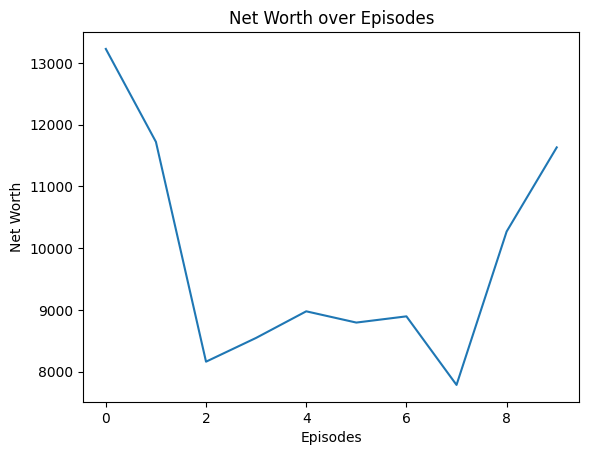

In [7]:
print(net_worths)
# Plotting the net worth over episodes
plt.plot(range(episodes), net_worths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()

episode: 1/10 score: 8203.434864554347
episode: 2/10 score: 8290.157943278455
episode: 3/10 score: 8428.721845913935
episode: 4/10 score: 9130.948896868376
episode: 5/10 score: 8468.182382344918
episode: 6/10 score: 8880.08149250692
episode: 7/10 score: 8745.362606057804
episode: 8/10 score: 8527.013708675508
episode: 9/10 score: 8459.865694718445
episode: 10/10 score: 8541.734534728053


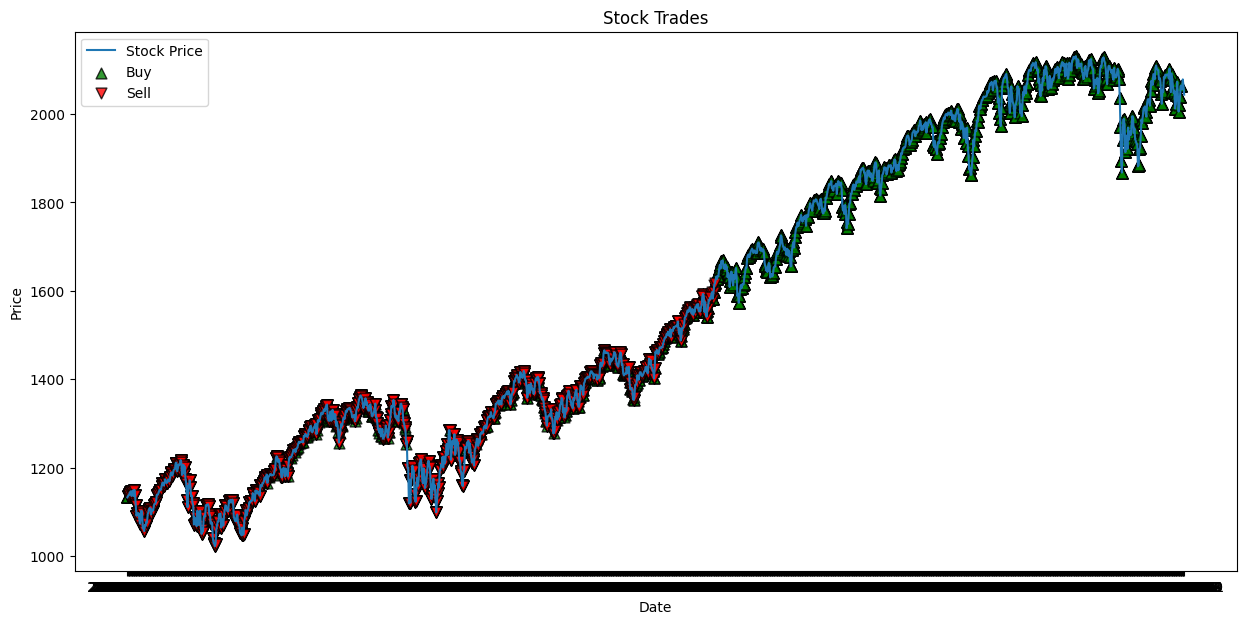

<Figure size 640x480 with 0 Axes>

In [8]:
# Evaluation
def evaluate(env, agent, episodes=10):
    # total_rewards = 0
    networths = []
    for e in range(episodes):
        trades = []
        state, _ = env.reset()
        state = state.flatten()
        for time in range(len(env.df)):
            action = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)
            trades.append((env.current_step, action[0], action[1]))  # Log the trade action
            next_state = next_state.flatten()
            # total_rewards += reward
            state = next_state
        plt.figure(figsize=(15, 7))

        # Plot stock price with a thinner line
        plt.plot(env.df['Date'], env.df['Close'], label='Stock Price', linewidth=1, color='b')

        # Extract buy and sell trades
        buy_trades = [trade for trade in trades if trade[1] == 0]
        sell_trades = [trade for trade in trades if trade[1] == 1]

        plt.scatter(env.df.loc[[trade[0] for trade in sell_trades], 'Date'], 
                    env.df.loc[[trade[0] for trade in sell_trades], 'Close'], 
                    marker='v', color='r', s=40, label='Sell', alpha=1)
        
        plt.scatter(env.df.loc[[trade[0] for trade in buy_trades], 'Date'], 
                    env.df.loc[[trade[0] for trade in buy_trades], 'Close'], 
                    marker='^', color='g', s=40, label='Buy', alpha=0.6)


        # Labels and title
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Stock Trades')

        # Show legend
        plt.legend()

        # Show plot
        plt.show()
        print(f"episode: {e+1}/{episodes} score: {env.net_worth}")
        networths.append(env.net_worth)
    
    print(f"Average net worth over {episodes} episodes: {sum(networths)/episodes}")
    

# Evaluate the agent
# agent = Agent(state_dim=state_dim)
agent = DDQNAgent(state_dim=state_dim,is_eval=True, model_name="model_ddqn_10.pth")
evaluate(env, agent)
plt.savefig('saved_visuals/ddqn_eval1.jpeg')